Quantum Key Exchange Successful!
Generated Key (32 bytes): 6d1efe42efacc454869354ca173f34fa15d7fdc7fa77e33dd15d4688708bdae4

Original Message: Mars Life Detection: POSITIVE (Confidence 99.7%)
Encrypted Message (hex): 80f20cc1dc2d662f0b90aad88e8153e4f3fbd082e67dcb5565...


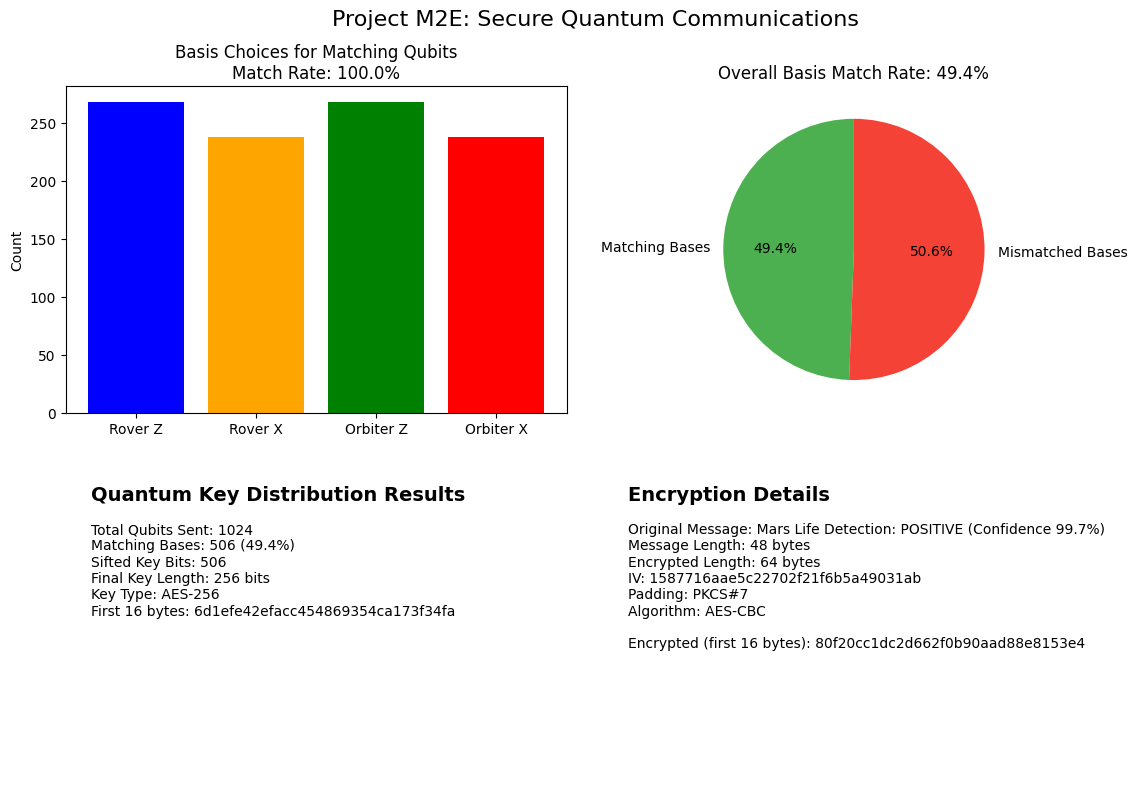

In [1]:
import numpy as np
import os
from qiskit_aer import Aer
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

def bb84_qkd(min_key_bits=256):
    """
    Generate a quantum key using BB84 protocol with guaranteed minimum length
    for AES encryption (min_key_bits must be 128, 192, or 256)i
    """
    # Calculate how many qubits we need to generate (account for 50% basis mismatch)
    qubits_needed = max(4 * min_key_bits, 1024)  # Ensure we have enough for key and error checking
    
    # 1. Generate random bits and bases for both parties
    rover_bits = np.random.randint(2, size=qubits_needed)
    rover_bases = np.random.randint(2, size=qubits_needed)  # 0=Z-basis, 1=X-basis
    orbiter_bases = np.random.randint(2, size=qubits_needed)
    
    # 2. Simulate quantum communication
    backend = Aer.get_backend('qasm_simulator')
    sifted_key = []
    matching_basis_indices = []  # Track indices where bases matched
    
    for i in range(qubits_needed):
        qc = QuantumCircuit(1, 1)
        
        # Rover prepares the qubit
        if rover_bits[i] == 1:
            qc.x(0)
        if rover_bases[i] == 1:  # Use X-basis
            qc.h(0)
        
        # Orbiter measures in their chosen basis
        if orbiter_bases[i] == 1:  # Measure in X-basis
            qc.h(0)
        qc.measure(0, 0)
        
        # Execute the circuit
        job = backend.run(qc, shots=1)
        result = job.result()
        counts = result.get_counts()
        measured_bit = int(list(counts.keys())[0])
        
        # 3. Sift key when bases match
        if rover_bases[i] == orbiter_bases[i]:
            sifted_key.append(measured_bit)
            matching_basis_indices.append(i)
    
    # 4. Estimate error rate (eavesdropping detection)
    sample_size = min(len(sifted_key) // 4, 128)  # Use up to 128 bits for error checking
    if sample_size > 0:
        sample_indices = np.random.choice(len(sifted_key), sample_size, replace=False)
        error_count = 0
        
        for idx in sample_indices:
            # Get the original bit index that corresponds to this sifted key position
            original_bit_index = matching_basis_indices[idx]
            
            if sifted_key[idx] != rover_bits[original_bit_index]:
                error_count += 1
        
        error_rate = error_count / sample_size
        if error_rate > 0.12:
            print(f"Eavesdropping detected! Error rate: {error_rate:.2f}")
            return None, rover_bases, orbiter_bases, sifted_key, matching_basis_indices
    
    # 5. Convert to bytes for practical use, ensuring correct key length
    # Determine how many bits we need to keep (must be multiple of 128 for AES)
    bits_to_keep = (min_key_bits // 128) * 128
    if bits_to_keep > len(sifted_key):
        print(f"Warning: Only {len(sifted_key)} bits available, need {bits_to_keep}")
        bits_to_keep = (len(sifted_key) // 128) * 128
    
    # Take the first 'bits_to_keep' bits
    final_bits = sifted_key[:bits_to_keep]
    
    # Convert to bytes
    byte_key = bytearray()
    for i in range(0, bits_to_keep, 8):
        byte_val = 0
        for j in range(8):
            if i+j < len(final_bits):
                byte_val |= final_bits[i+j] << (7 - j)
        byte_key.append(byte_val)
    
    return bytes(byte_key), rover_bases, orbiter_bases, sifted_key, matching_basis_indices

# ===== MAIN DEMONSTRATION =====
if __name__ == "__main__":
    # Generate quantum key (256-bit for AES-256)
    quantum_key, rover_bases, orbiter_bases, sifted_key, matching_indices = bb84_qkd(min_key_bits=256)
    
    if quantum_key is None:
        print("Key exchange aborted due to suspected eavesdropping!")
    else:
        print(f"Quantum Key Exchange Successful!")
        print(f"Generated Key ({len(quantum_key)} bytes): {quantum_key.hex()}")
        
        # Encrypt sample message
        iv = os.urandom(16)
        
        # Verify key length is valid for AES
        valid_key_lengths = {16: "AES-128", 24: "AES-192", 32: "AES-256"}
        if len(quantum_key) not in valid_key_lengths:
            # Find the closest valid key length
            valid_len = min(valid_key_lengths.keys(), key=lambda x: abs(x - len(quantum_key)))
            # Pad or truncate the key to valid length
            if len(quantum_key) < valid_len:
                quantum_key = quantum_key + os.urandom(valid_len - len(quantum_key))
            else:
                quantum_key = quantum_key[:valid_len]
            print(f"Adjusted key to {valid_key_lengths[valid_len]} ({valid_len} bytes)")
        
        cipher = Cipher(algorithms.AES(quantum_key), modes.CBC(iv), backend=default_backend())
        encryptor = cipher.encryptor()
        
        message = b"Mars Life Detection: POSITIVE (Confidence 99.7%)"
        pad_length = 16 - (len(message) % 16)
        padded_msg = message + bytes([pad_length]) * pad_length
        ciphertext = encryptor.update(padded_msg) + encryptor.finalize()
        
        print("\nOriginal Message:", message.decode())
        print("Encrypted Message (hex):", ciphertext.hex()[:50] + "...")
        
        # Visualization
        plt.figure(figsize=(12, 8))
        
        # Basis comparison
        plt.subplot(2, 2, 1)
        # Calculate match rate only for positions where bases matched
        if len(matching_indices) > 0:
            rover_matching = rover_bases[matching_indices]
            orbiter_matching = orbiter_bases[matching_indices]
            match_percent = 100.0  # Since we're only looking at matching bases
        else:
            rover_matching = np.array([])
            orbiter_matching = np.array([])
            match_percent = 0.0
        
        basis_counts = [np.sum(rover_matching == 0), np.sum(rover_matching == 1),
                       np.sum(orbiter_matching == 0), np.sum(orbiter_matching == 1)]
        labels = ['Rover Z', 'Rover X', 'Orbiter Z', 'Orbiter X']
        colors = ['blue', 'orange', 'green', 'red']
        plt.bar(labels, basis_counts, color=colors)
        plt.title(f'Basis Choices for Matching Qubits\nMatch Rate: {match_percent:.1f}%')
        plt.ylabel('Count')
        
        # Basis match rate visualization
        plt.subplot(2, 2, 2)
        total_qubits = len(rover_bases)
        match_rate = len(matching_indices) / total_qubits * 100
        plt.pie([match_rate, 100 - match_rate], 
                labels=['Matching Bases', 'Mismatched Bases'],
                colors=['#4CAF50', '#F44336'],
                autopct='%1.1f%%',
                startangle=90)
        plt.title(f'Overall Basis Match Rate: {match_rate:.1f}%')
        
        # Key information
        plt.subplot(2, 2, 3)
        plt.text(0.05, 0.85, "Quantum Key Distribution Results", fontsize=14, weight='bold')
        plt.text(0.05, 0.75, f"Total Qubits Sent: {total_qubits}")
        plt.text(0.05, 0.70, f"Matching Bases: {len(matching_indices)} ({match_rate:.1f}%)")
        plt.text(0.05, 0.65, f"Sifted Key Bits: {len(sifted_key)}")
        plt.text(0.05, 0.60, f"Final Key Length: {len(quantum_key)*8} bits")
        plt.text(0.05, 0.55, f"Key Type: {valid_key_lengths.get(len(quantum_key), 'Custom')}")
        plt.text(0.05, 0.50, f"First 16 bytes: {quantum_key[:16].hex()}")
        plt.axis('off')
        
        # Encryption information
        plt.subplot(2, 2, 4)
        plt.text(0.05, 0.85, "Encryption Details", fontsize=14, weight='bold')
        plt.text(0.05, 0.75, f"Original Message: {message.decode()}")
        plt.text(0.05, 0.70, f"Message Length: {len(message)} bytes")
        plt.text(0.05, 0.65, f"Encrypted Length: {len(ciphertext)} bytes")
        plt.text(0.05, 0.60, f"IV: {iv.hex()}")
        plt.text(0.05, 0.55, f"Padding: PKCS#7")
        plt.text(0.05, 0.50, f"Algorithm: AES-CBC")
        plt.text(0.05, 0.40, f"Encrypted (first 16 bytes): {ciphertext[:16].hex()}")
        plt.axis('off')
        
        plt.suptitle("Project M2E: Secure Quantum Communications", fontsize=16)
        plt.tight_layout()
        plt.show()

In [ ]:
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt
from qiskit_aer import Aer
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from qiskit import QuantumCircuit
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import SPSA

def bb84_qkd(min_key_bits=256):
    """Quantum Key Distribution using BB84 protocol"""
    qubits_needed = max(4 * min_key_bits, 1024)
    
    rover_bits = np.random.randint(2, size=qubits_needed)
    rover_bases = np.random.randint(2, size=qubits_needed)
    orbiter_bases = np.random.randint(2, size=qubits_needed)
    
    backend = Aer.get_backend('qasm_simulator')
    sifted_key = []
    matching_indices = []
    
    for i in range(qubits_needed):
        qc = QuantumCircuit(1, 1)
        
        if rover_bits[i] == 1:
            qc.x(0)
        if rover_bases[i] == 1:
            qc.h(0)
        if orbiter_bases[i] == 1:
            qc.h(0)
        
        qc.measure(0, 0)
        
        job = backend.run(qc, shots=1)
        result = job.result()
        counts = result.get_counts()
        measured_bit = int(list(counts.keys())[0])
        
        if rover_bases[i] == orbiter_bases[i]:
            sifted_key.append(measured_bit)
            matching_indices.append(i)
    
    # Convert to bytes
    byte_key = bytearray()
    for i in range(0, len(sifted_key) - len(sifted_key) % 8, 8):
        byte_val = sum(bit << (7 - j) for j, bit in enumerate(sifted_key[i:i+8]))
        byte_key.append(byte_val)
    
    return bytes(byte_key), rover_bases, orbiter_bases, sifted_key, matching_indices

def optimize_route():
    """Optimization of satellite routing path"""
    # Create space communication network
    G = nx.DiGraph()
    
    # Add nodes
    nodes = ["A: Mars Orbiter", "B: Lunar Gateway", "C: Deep Space Relay", "D: Earth DSN"]
    G.add_nodes_from(nodes)
    
    # Add edges with transmission costs (time delay + energy)
    G.add_edge(nodes[0], nodes[1], weight=4)   # A → B
    G.add_edge(nodes[0], nodes[2], weight=2)   # A → C
    G.add_edge(nodes[0], nodes[3], weight=10)  # A → D (direct)
    G.add_edge(nodes[1], nodes[3], weight=3)   # B → D
    G.add_edge(nodes[2], nodes[3], weight=8)   # C → D
    G.add_edge(nodes[1], nodes[2], weight=1)   # B → C
    G.add_edge(nodes[2], nodes[1], weight=1)   # C → B
    
    # Formulate as quadratic program
    qp = QuadraticProgram()
    
    # Create binary variables for each edge
    edge_vars = {}
    for u, v in G.edges():
        var_name = f"edge_{u[0]}{v[0]}"
        qp.binary_var(name=var_name)
        edge_vars[(u, v)] = var_name
    
    # Objective: minimize total cost
    linear = {}
    for (u, v), var_name in edge_vars.items():
        linear[var_name] = G[u][v]['weight']
    qp.minimize(linear=linear)
    
    # Constraints:
    # 1. Start at A: exactly one outgoing edge
    start_edges = [var_name for (u, v), var_name in edge_vars.items() if u == nodes[0]]
    qp.linear_constraint(linear={var: 1 for var in start_edges}, sense="==", rhs=1)
    
    # 2. End at D: exactly one incoming edge
    end_edges = [var_name for (u, v), var_name in edge_vars.items() if v == nodes[3]]
    qp.linear_constraint(linear={var: 1 for var in end_edges}, sense="==", rhs=1)
    
    # 3. Flow conservation at intermediate nodes
    for node in nodes[1:3]:  # B and C
        in_edges = [var_name for (u, v), var_name in edge_vars.items() if v == node]
        out_edges = [var_name for (u, v), var_name in edge_vars.items() if u == node]
        
        # Flow in = flow out
        qp.linear_constraint(
            linear={**{var: 1 for var in in_edges}, **{var: -1 for var in out_edges}},
            sense="==", 
            rhs=0
        )
    
    # Solve with quantum or classical optimizer
    try:
        # Try quantum optimization
        quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'))
        optimizer = SPSA(maxiter=100)
        ansatz = RealAmplitudes(len(edge_vars))
        vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=quantum_instance)
        algo = MinimumEigenOptimizer(vqe)
        result = algo.solve(qp)
        method = "Quantum (VQE)"
    except Exception as e:
        print(f"⚠️ Quantum optimization failed: {str(e)}")
        print("🔄 Falling back to classical optimization")
        from qiskit_optimization.algorithms import CplexOptimizer
        algo = CplexOptimizer() if hasattr(CplexOptimizer, 'solve') else MinimumEigenOptimizer(None)
        result = algo.solve(qp)
        method = "Classical"
    
    # Extract the optimal path
    optimal_path = []
    for (u, v), var_name in edge_vars.items():
        if result.x[list(edge_vars.values()).index(var_name)] > 0.5:
            optimal_path.append((u, v))
    
    return G, nodes, result, optimal_path, method

def visualize_network(G, nodes, optimal_path, method):
    """Visualize the space communication network with optimal path"""
    plt.figure(figsize=(12, 8))
    
    # Node positions
    pos = {
        nodes[0]: (0, 0.5),   # Mars Orbiter
        nodes[1]: (0.5, 1),   # Lunar Gateway
        nodes[2]: (0.5, 0),   # Deep Space Relay
        nodes[3]: (1, 0.5)    # Earth DSN
    }
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=2500, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # Draw all edges
    all_edges = list(G.edges())
    nx.draw_networkx_edges(G, pos, edgelist=all_edges, width=1, alpha=0.3, 
                           connectionstyle='arc3,rad=0.1', arrows=True)
    
    # Draw optimal path
    nx.draw_networkx_edges(G, pos, edgelist=optimal_path, width=3, edge_color='red',
                           connectionstyle='arc3,rad=0.1', arrows=True)
    
    # Edge labels (weights)
    edge_labels = {(u, v): f"{G[u][v]['weight']}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    
    plt.title(f"Deep Space Communication Network\nOptimal Path in Red ({method})", fontsize=16)
    plt.axis('off')
    return plt

def space_mission_demo():
    """End-to-end demonstration of Project M2E"""
    # Stage 1: Quantum Key Distribution
    print("🚀 Stage 1: Quantum Key Distribution (Rover to Orbiter)")
    quantum_key, _, _, _, _ = bb84_qkd(256)
    
    # Adjust key for AES
    valid_key_lengths = {16: "AES-128", 24: "AES-192", 32: "AES-256"}
    valid_len = min(valid_key_lengths.keys(), key=lambda x: abs(x - len(quantum_key)))
    quantum_key = quantum_key[:valid_len] if len(quantum_key) > valid_len else quantum_key + os.urandom(valid_len - len(quantum_key))
    
    print(f"🔑 Generated {valid_key_lengths[valid_len]} Key: {quantum_key[:8].hex()}...")
    
    # Encrypt mission data
    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(quantum_key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    
    message = b"Mars Life Detection: POSITIVE (Confidence 99.7%)"
    pad_length = 16 - (len(message) % 16)
    padded_msg = message + bytes([pad_length]) * pad_length
    ciphertext = encryptor.update(padded_msg) + encryptor.finalize()
    
    print(f"🔒 Encrypted Mission Data: {ciphertext[:16].hex()}...")
    
    # Stage 2: Routing Optimization
    print("\n🛰️ Stage 2: Finding Optimal Route (Orbiter to Earth)")
    G, nodes, result, optimal_path, method = optimize_route()
    
    # Calculate total cost
    total_cost = sum(G[u][v]['weight'] for u, v in optimal_path)
    
    # Print route information
    print(f"⚡ Optimal Path: {' → '.join([u.split(':')[1].strip() for u, v in optimal_path])} → Earth DSN")
    print(f"💡 Total Transmission Cost: {total_cost}")
    print(f"🔧 Optimization Method: {method}")
    
    # Visualization
    plt = visualize_network(G, nodes, optimal_path, method)
    plt.tight_layout()
    plt.show()
    
    # Display mission summary
    print("\n✅ Mission Summary:")
    print(f"- Secure Key Established: {valid_key_lengths[valid_len]}")
    print(f"- Mission Data Size: {len(message)} bytes")
    print(f"- Optimal Route: {' → '.join([u.split(':')[1].strip() for u, v in optimal_path])} → Earth DSN")
    print(f"- Total Transmission Cost: {total_cost}")
    print(f"- Optimization Method: {method}")
    print("- Status: DATA TRANSMISSION SUCCESSFUL")

# Run the complete mission
if __name__ == "__main__":
    space_mission_demo()